In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_60 import VitalSignsDataset,vital_pre_train
from model_train.model.retnet.cvae.autoencoder_v5_retnet_conditional import *
from model_train.model.retnet.cvae.autoencoder_v5_loss_train_conditional import *
from model.retnet.cvae.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


from torchsampler import ImbalancedDatasetSampler

2025-06-05 10:03:54.455704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=16, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_60_conditional"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=200, save_dir=stage1_dir, patience=50,kl_warmup_epochs=120)

[Epoch 50] KL weight: 0.0041, KL: 2.0739
[VAE Pretrain] Epoch 50/200 Avg ELBO: -406.6586 (Recon: -408.7326, KLw: 2.0739)
[Epoch 100] KL weight: 0.0083, KL: 4.1664
[VAE Pretrain] Epoch 100/200 Avg ELBO: -446.1064 (Recon: -450.2728, KLw: 4.1664)
[Epoch 150] KL weight: 0.0100, KL: 4.8221
[VAE Pretrain] Epoch 150/200 Avg ELBO: -493.3657 (Recon: -498.1878, KLw: 4.8221)
[Epoch 200] KL weight: 0.0100, KL: 4.9282
[VAE Pretrain] Epoch 200/200 Avg ELBO: -498.7562 (Recon: -503.6843, KLw: 4.9282)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=40)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0178
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0180
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0178
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0177
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0178
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0178
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0165
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0165
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0165


In [5]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_60_conditional/stage2/best_som.pth'
model2 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

<All keys matched successfully>

In [6]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model2, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience =20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


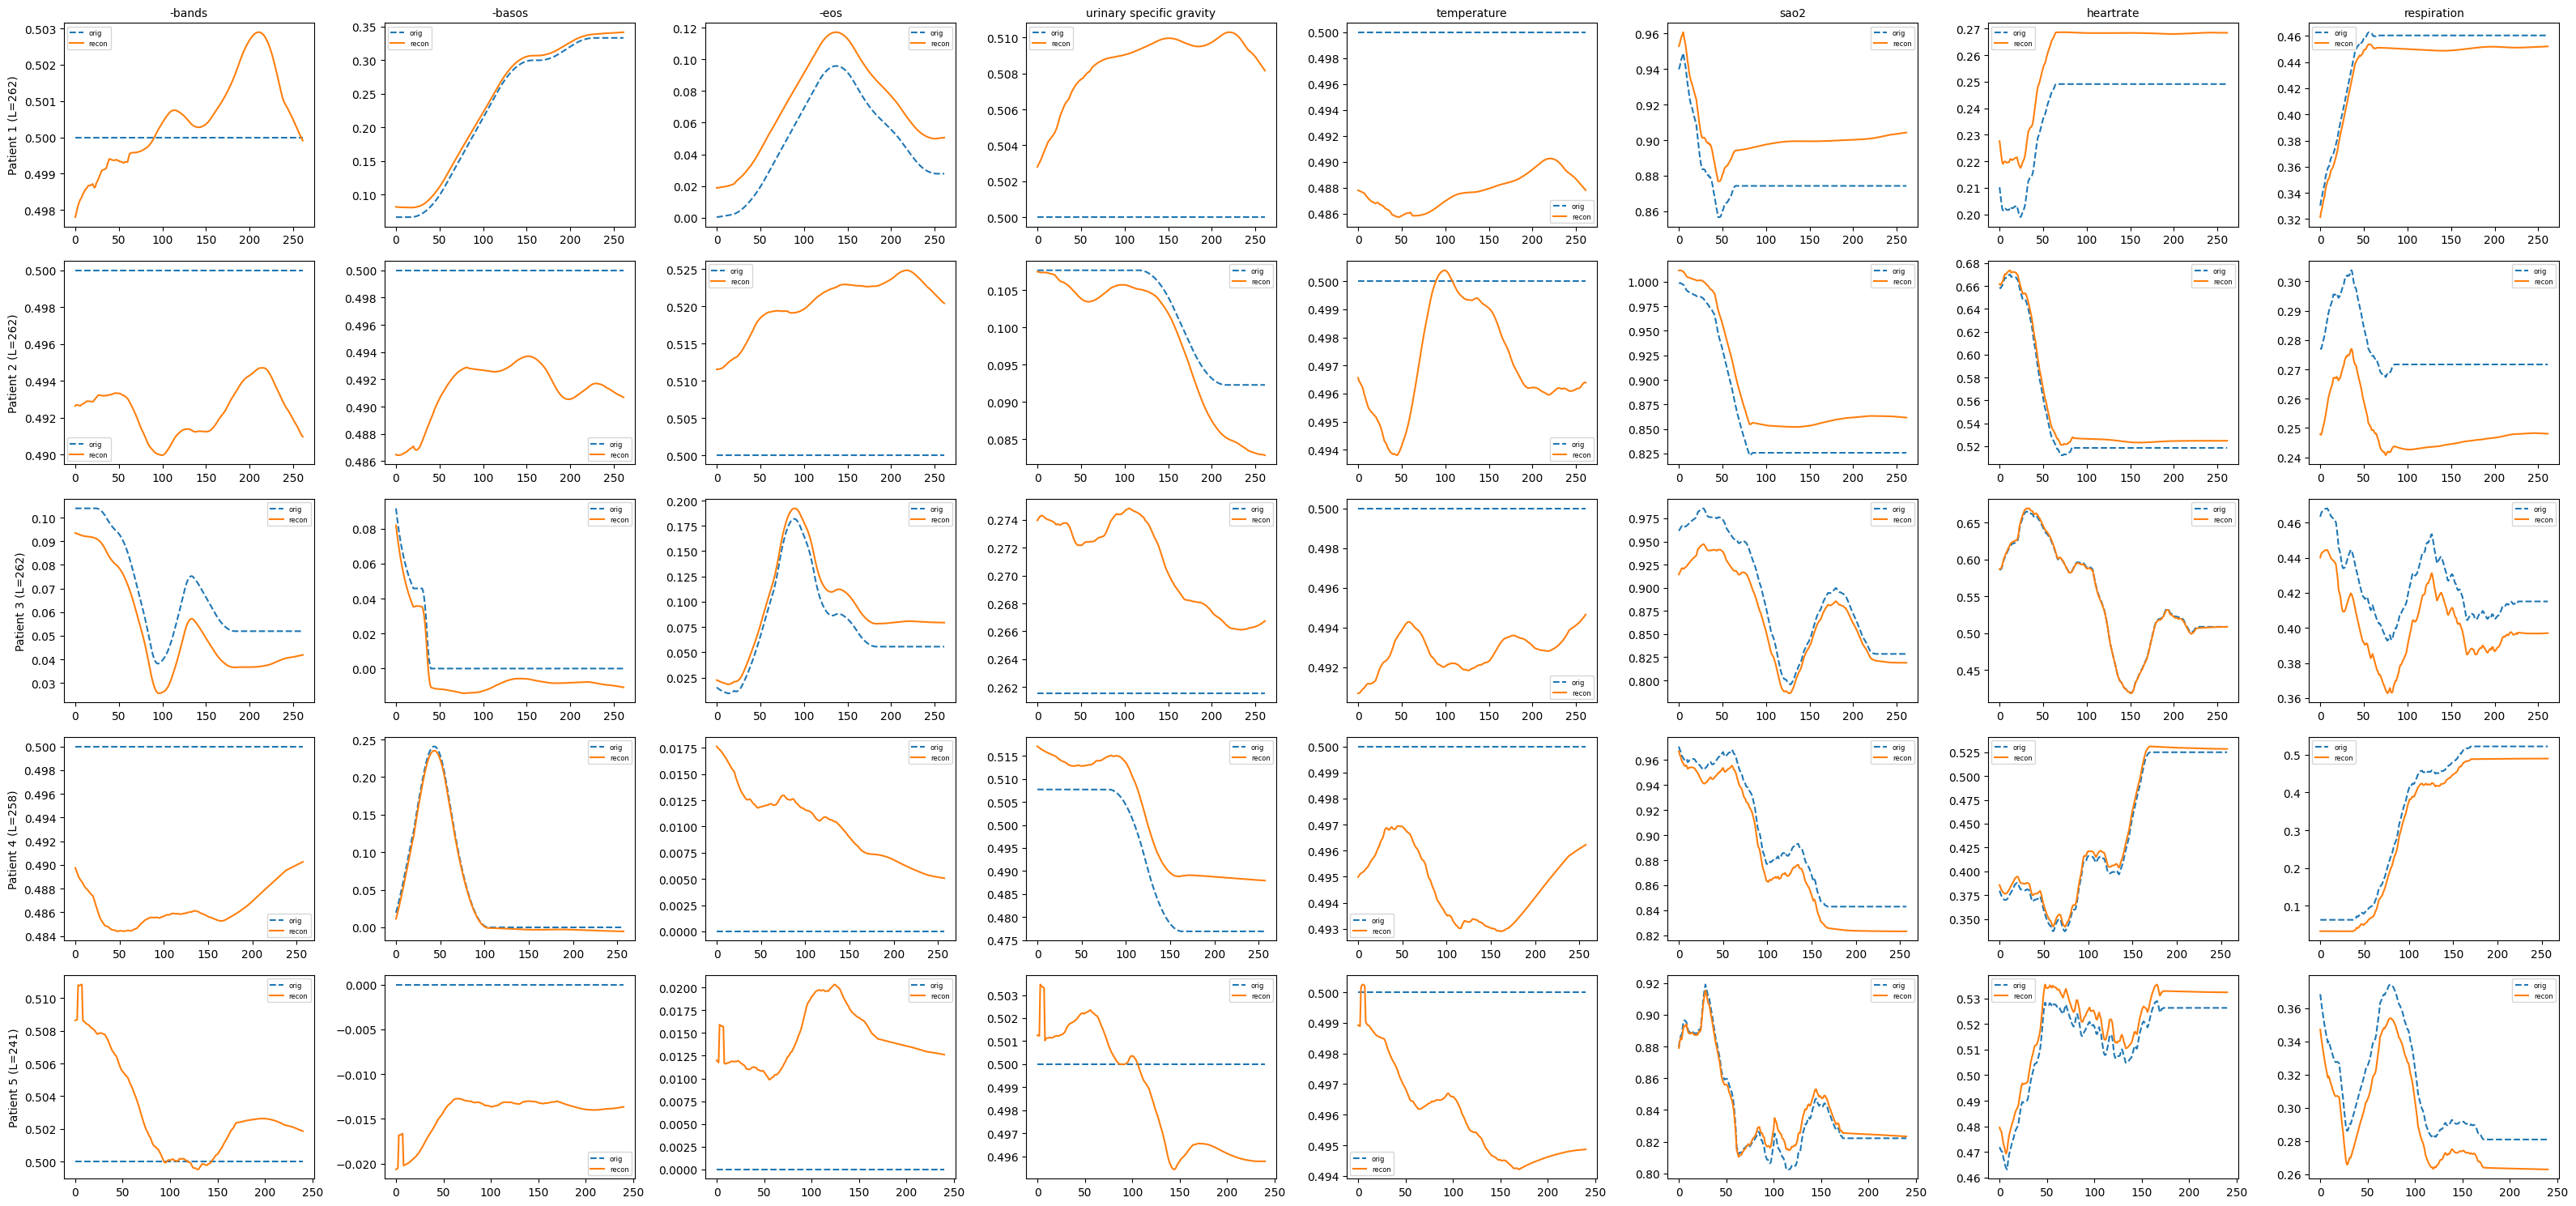

In [7]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 79950 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0064
  Std (overall): 0.1953
  Per-dim mean:
tensor([-1.4354e-02,  7.9948e-03,  8.0748e-01,  1.0654e-02,  2.1758e-02,
         3.9180e-01,  1.4875e-02,  1.4874e-03,  1.8136e-03, -1.3242e-03,
        -2.2207e-02, -1.7125e-02, -4.5466e-02, -3.4552e-02,  5.4975e-02,
        -1.3929e-03,  2.2308e-01, -5.6030e-02,  3.4249e-02,  1.6361e-02,
        -5.8506e-04,  4.7374e-02,  7.1414e-03, -3.9125e-03, -3.1677e-02,
         3.0724e-02, -2.4696e-02,  1.3190e-02,  2.6103e-02, -3.5829e-02,
        -4.8668e-01, -1.6306e-02, -4.4052e-02, -4.8076e-01,  3.6340e-02,
         4.5545e-02,  2.4942e-02, -2.2240e-02, -4.8468e-03,  1.6071e-03,
        -4.1027e-02,  1.4048e-02,  3.0948e-02,  2.8450e-02, -1.1276e-02,
         3.0266e-02, -6.9769e-02,  2.1100e-02, -4.8364e-03,  7.9831e-02,
        -7.0262e-03, -1.6897e-02,  2.1931e-02,  4.2835e-03,  2.7181e-02,
        -1.0715e-02,  1.4241e-02, -3.4

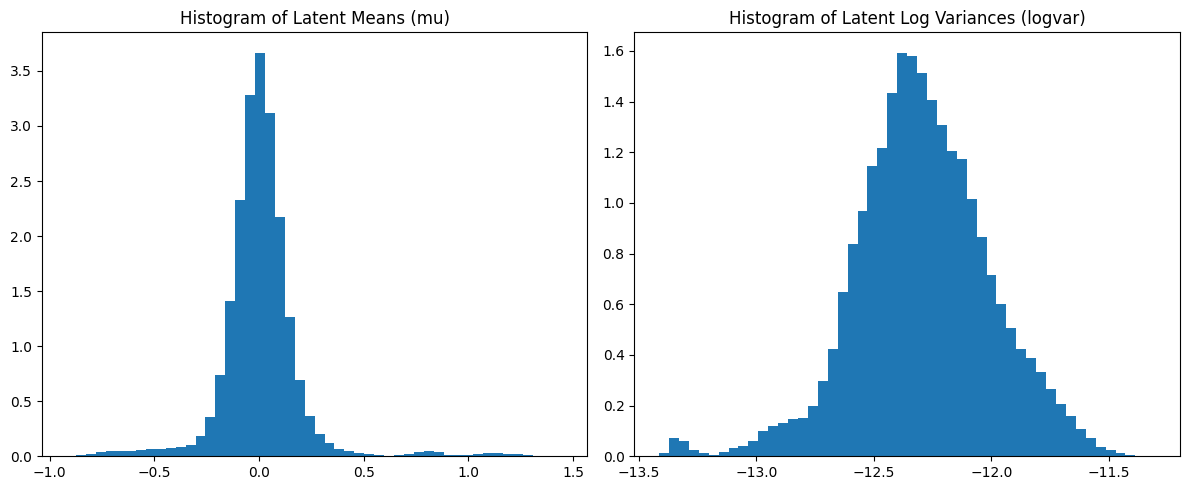

In [8]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

### vae 几乎退化成 ae， logvar=-10， 无随机性， kl值过大，与先验不服和

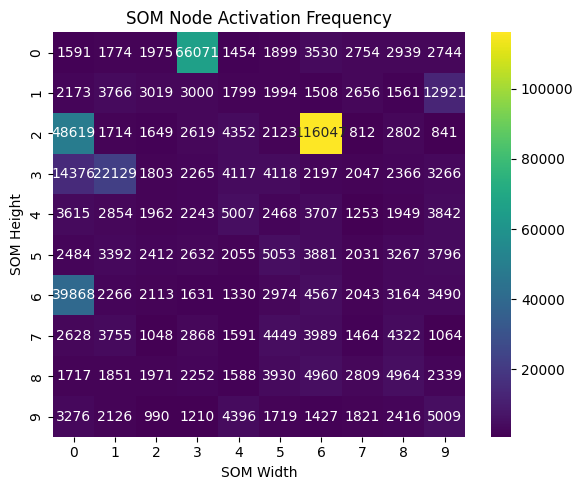

In [ ]:
activation_map = compute_som_activation_heatmap(model3,train_loader, device)
plot_som_activation_heatmap(activation_map)

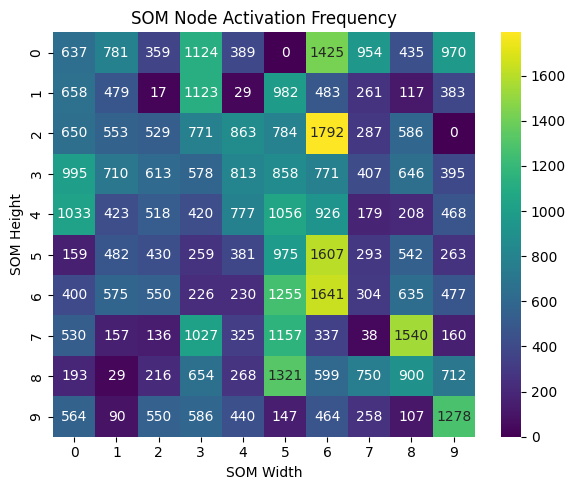

In [23]:
activation_map = compute_som_activation_heatmap(model3,test_loader, device, som_dim=(10, 10))
plot_som_activation_heatmap(activation_map)

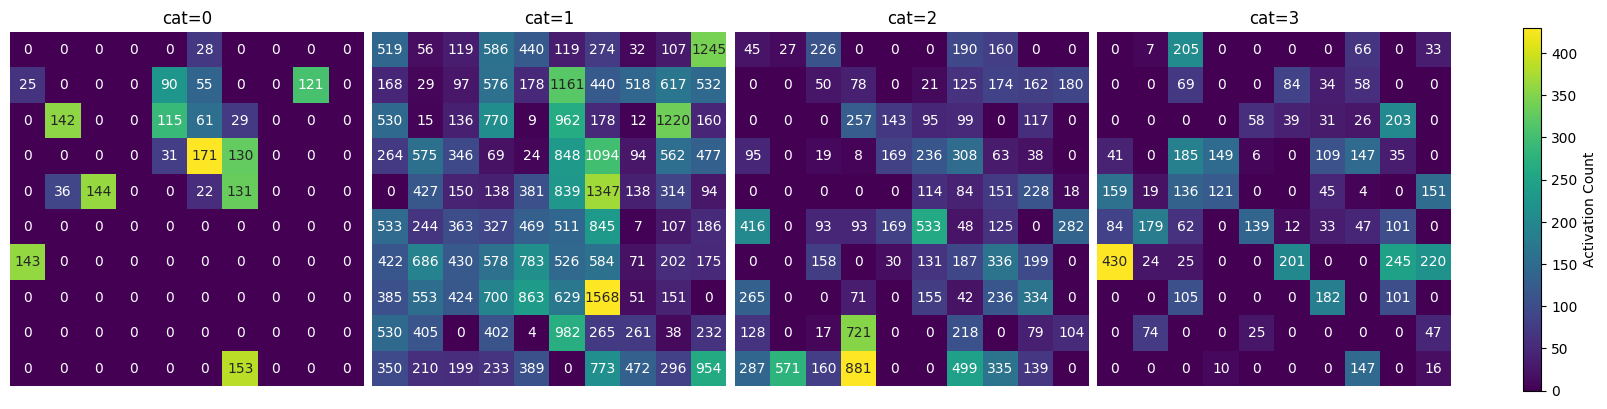

In [ ]:

som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

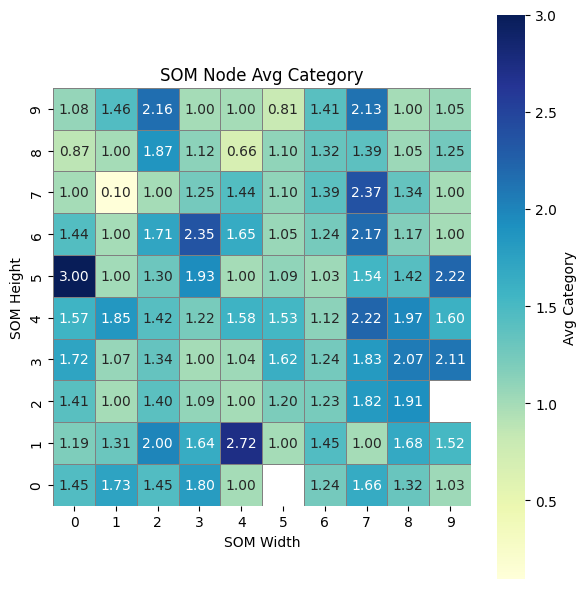

In [ ]:


som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)

z_all shape: (59412, 128)
y_all shape: (59412,)


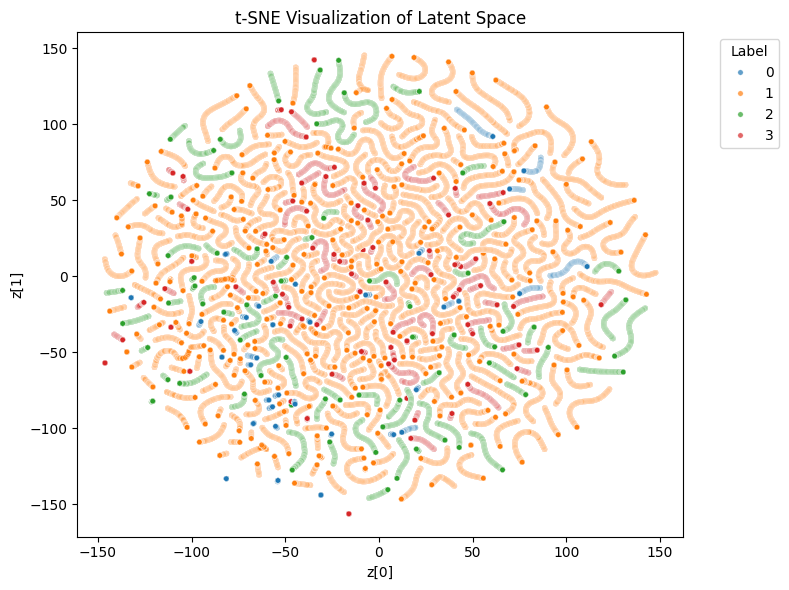

In [10]:
z_all, y_all = collect_latents(model3, data_loader= train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


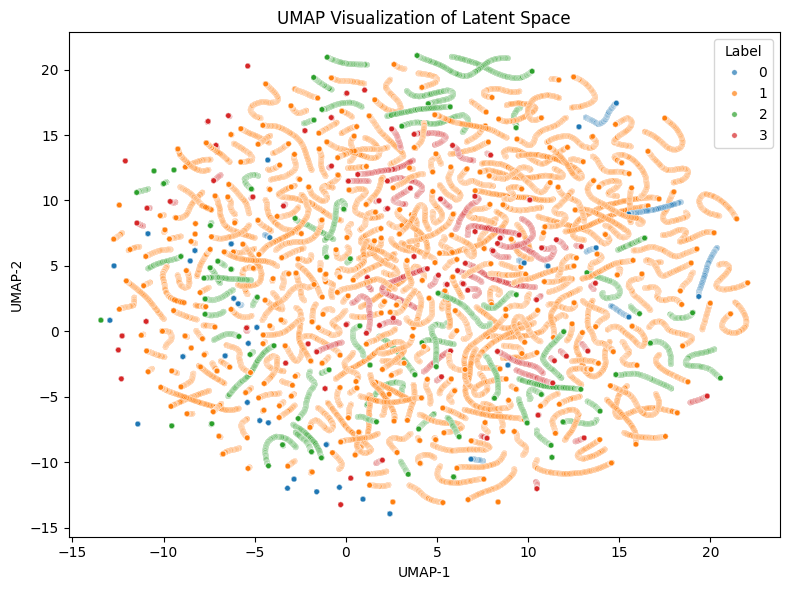

In [11]:
plot_umap(z_all, y_all)